## **Sentiment Analysis on Movie Reviews**

### **About the Dataset**

Dataset obtained from: https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data

**train.tsv**: contains the phrases and their associated sentiment labels and SentenceId to track which phrases belong to a single sentence.

**test.tsv**: contains just phrases. To assign a sentiment label to each phrase.


The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive


### **Project goals**

The goal of the project is to use the dataset above to perform sentiment analysis on these movie reviews, that is, to classify the sentiment of sentences from this Rotten Tomatoes dataset.

#### **Import libraries**

In [ ]:
import numpy as np 
import pandas as pd 
import nltk
import os
import gc
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)

In [ ]:
gc.collect()

41

#### **Read and explore data**

In [ ]:
train_df = pd.read_table('/content/drive/MyDrive/Deep Learning/Assignment: Sentiment Analysis on Movie Reviews/train.tsv')
test_df = pd.read_table('/content/drive/MyDrive/Deep Learning/Assignment: Sentiment Analysis on Movie Reviews/test.tsv')

In [ ]:
train_df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [ ]:
test_df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


***Sentences from original dataset were split in separate phrases and each of them has a sentiment label.***

In [ ]:
print(train_df.shape, test_df.shape)

(156060, 4) (66292, 3)


In [ ]:
# To check dataset for SentenceId = 2 
train_df.loc[train_df.SentenceId == 2]

,PhraseId,SentenceId,Phrase,Sentiment
63,64,2,"This quiet , introspective and entertaining independent is worth seeking .",4
64,65,2,"This quiet , introspective and entertaining independent",3
65,66,2,This,2
66,67,2,"quiet , introspective and entertaining independent",4
67,68,2,"quiet , introspective and entertaining",3
68,69,2,quiet,2
69,70,2,", introspective and entertaining",3
70,71,2,introspective and entertaining,3
71,72,2,introspective and,3
72,73,2,introspective,2


In [ ]:
# To check any other different values other than 0 to 4
train_df['Sentiment'].unique()

array([1, 2, 3, 4, 0])

In [ ]:
train_df["Sentiment"].value_counts().sort_index()

0    7072 
1    27273
2    79582
3    32927
4    9206 
Name: Sentiment, dtype: int64

In [ ]:
train_df["Sentiment"].value_counts(normalize=True).sort_index()

0    0.045316
1    0.174760
2    0.509945
3    0.210989
4    0.058990
Name: Sentiment, dtype: float64

In [ ]:
train_df.groupby("Sentiment").nunique()

,PhraseId,SentenceId,Phrase
Sentiment,,,
0,7072,2609,7072
1,27273,6001,27273
2,79582,8115,79582
3,32927,6699,32927
4,9206,3123,9206


In [ ]:
train_df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [ ]:
test_df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
dtype: int64

**Adding Sentiment column to test dataset and joing train and test for preprocessing**

In [ ]:
test_df['Sentiment']=-999
test_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,-999
1,156062,8545,An intermittently pleasing but mostly routine effort,-999
2,156063,8545,An,-999
3,156064,8545,intermittently pleasing but mostly routine effort,-999
4,156065,8545,intermittently pleasing but mostly routine,-999


In [ ]:
df=pd.concat([train_df,test_df],ignore_index=True)
print(df.shape)
df.tail()

(222352, 4)


,PhraseId,SentenceId,Phrase,Sentiment
222347,222348,11855,"A long-winded , predictable scenario .",-999
222348,222349,11855,"A long-winded , predictable scenario",-999
222349,222350,11855,"A long-winded ,",-999
222350,222351,11855,A long-winded,-999
222351,222352,11855,predictable scenario,-999


In [ ]:
del train_df,test_df
gc.collect()

0

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

In [ ]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df['clean_review']=clean_review(df.Phrase.values)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,a series of escapade demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amount to much of a story
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,a series of escapade demonstrating the adage that what is good for the goose
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


**Seperating train and test dataset**

In [ ]:
df_train=df[df.Sentiment!=-999]
df_train.shape

(156060, 5)

In [ ]:
df_test=df[df.Sentiment==-999]
df_test.drop('Sentiment',axis=1,inplace=True)
print(df_test.shape)
df_test.head()

(66292, 4)


,PhraseId,SentenceId,Phrase,clean_review
156060,156061,8545,An intermittently pleasing but mostly routine effort .,an intermittently pleasing but mostly routine effort
156061,156062,8545,An intermittently pleasing but mostly routine effort,an intermittently pleasing but mostly routine effort
156062,156063,8545,An,an
156063,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing but mostly routine effort
156064,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing but mostly routine


In [ ]:
del df
gc.collect()

0

**Splitting Train dataset into 80% train and 20% validation set**

In [ ]:
train_text=df_train.clean_review.values
test_text=df_test.clean_review.values
target=df_train.Sentiment.values
y=to_categorical(target)
print(train_text.shape,target.shape,y.shape)

(156060,) (156060,) (156060, 5)


In [ ]:
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(124848,) (124848, 5)
(31212,) (31212, 5)


**Finding number of unique words in train set**

In [ ]:
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

13732

**Finding max length of a review in train set**

In [ ]:
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

48

**Building Keras LSTM model**

In [ ]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 10
num_classes=5

**Tokenize Text**

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)

**sequence padding**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


### **1. LSTM model**

In [ ]:
model1=Sequential()
model1.add(Embedding(max_features,100,mask_zero=True))
model1.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model1.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model1.add(Dense(num_classes,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1373200   
                                                                 
 lstm (LSTM)                 (None, None, 64)          42240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 1,428,021
Trainable params: 1,428,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history1=model1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/10
976/976 [==============================] - 427s 430ms/step - loss: 1.3946 - accuracy: 0.5073 - val_loss: 1.2660 - val_accuracy: 0.5126
Epoch 2/10
976/976 [==============================] - 417s 427ms/step - loss: 1.2075 - accuracy: 0.5267 - val_loss: 1.1473 - val_accuracy: 0.5483
Epoch 3/10
976/976 [==============================] - 417s 427ms/step - loss: 1.0975 - accuracy: 0.5672 - val_loss: 1.0558 - val_accuracy: 0.5913
Epoch 4/10
976/976 [==============================] - 412s 422ms/step - loss: 0.9992 - accuracy: 0.6050 - val_loss: 0.9735 - val_accuracy: 0.6187
Epoch 5/10
976/976 [==============================] - 412s 422ms/step - loss: 0.9207 - accuracy: 0.6326 - val_loss: 0.9198 - val_accuracy: 0.6360
Epoch 6/10
976/976 [==============================] - 424s 434ms/step - loss: 0.8683 - accuracy: 0.6514 - val_loss: 0.8896 - val_accuracy: 0.6465
Epoch 7/10
976/976 [==============================] - 414s 424ms/step - loss: 0.8329 - accuracy: 0.6629 - val_loss: 0.8713 -

In [ ]:
y_pred1=model1.predict(X_test,verbose=1)

2072/2072 [==============================] - 59s 28ms/step


In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/Deep Learning/Assignment: Sentiment Analysis on Movie Reviews/sampleSubmission.csv')

In [ ]:
predictions = np.argmax(y_pred1, axis=1).astype(int)
sub.Sentiment=predictions
sub.to_csv('sub1.csv', index=False)
sub.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


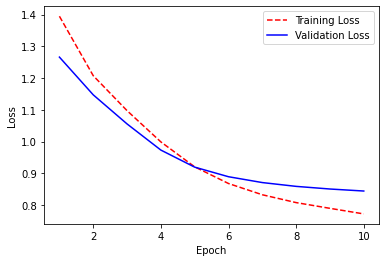

In [ ]:
epoch_count = range(1, len(history1.history['loss']) + 1)

plt.plot(epoch_count, history1.history['loss'], 'r--')
plt.plot(epoch_count, history1.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

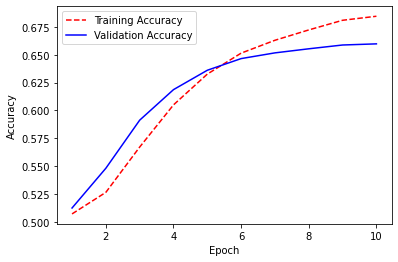

In [ ]:
epoch_count = range(1, len(history1.history['accuracy']) + 1)

plt.plot(epoch_count, history1.history['accuracy'], 'r--')
plt.plot(epoch_count, history1.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

####################################

### **2. CNN**

In [ ]:
model2= Sequential()
model2.add(Embedding(max_features,100,input_length=max_words))
model2.add(Dropout(0.2))

model2.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model2.add(GlobalMaxPooling1D())

model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(num_classes,activation='softmax'))

model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
%%time
history2=model2.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/10
976/976 [==============================] - 11s 10ms/step - loss: 1.0079 - accuracy: 0.5976 - val_loss: 0.8613 - val_accuracy: 0.6494
Epoch 2/10
976/976 [==============================] - 8s 8ms/step - loss: 0.7826 - accuracy: 0.6782 - val_loss: 0.8075 - val_accuracy: 0.6654
Epoch 3/10
976/976 [==============================] - 5s 5ms/step - loss: 0.7007 - accuracy: 0.7086 - val_loss: 0.8056 - val_accuracy: 0.6669
Epoch 4/10
976/976 [==============================] - 5s 5ms/step - loss: 0.6444 - accuracy: 0.7304 - val_loss: 0.8163 - val_accuracy: 0.6668
Epoch 5/10
976/976 [==============================] - 5s 5ms/step - loss: 0.5993 - accuracy: 0.7480 - val_loss: 0.8398 - val_accuracy: 0.6693
Epoch 6/10
976/976 [==============================] - 5s 5ms/step - loss: 0.5664 - accuracy: 0.7599 - val_loss: 0.8772 - val_accuracy: 0.6654
Epoch 7/10
976/976 [==============================] - 5s 5ms/step - loss: 0.5384 - accuracy: 0.7709 - val_loss: 0.9093 - val_accuracy: 0.6647
Epoc

In [ ]:
y_pred2=model2.predict(X_test, verbose=1)

2072/2072 [==============================] - 3s 1ms/step


In [ ]:
predictions2 = np.argmax(y_pred1, axis=1).astype(int)
sub.Sentiment=predictions2
sub.to_csv('sub2.csv', index=False)
sub.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


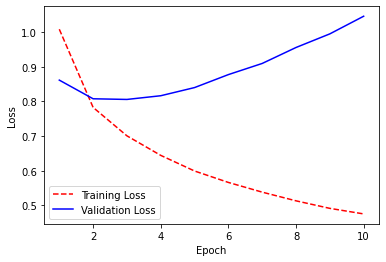

In [ ]:
epoch_count2 = range(1, len(history2.history['loss']) + 1)

plt.plot(epoch_count2, history2.history['loss'], 'r--')
plt.plot(epoch_count2, history2.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

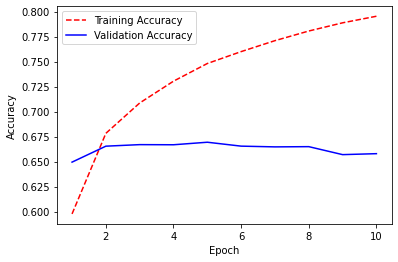

In [ ]:
epoch_count2 = range(1, len(history2.history['accuracy']) + 1)

plt.plot(epoch_count2, history2.history['accuracy'], 'r--')
plt.plot(epoch_count2, history2.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()